In [42]:
import os, json, sqlite3, requests
from pprint import pprint
from datetime import datetime, timedelta, UTC
from typing import TypedDict, Optional, Dict, Any
from config import DB_PATH, CRYPTO_API_TOKEN, API_BASE_URL, headers
from cryto_api import call_crypto_api

from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_classic.memory import ConversationBufferWindowMemory
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

from langgraph.checkpoint.memory import MemorySaver

from dotenv import load_dotenv
from typing_extensions import TypedDict, Annotated, List, Literal, Optional
from pydantic import BaseModel, Field
from IPython.display import Image, display, Markdown

load_dotenv()

True

In [43]:
# llm = ChatOpenAI(
#     temperature=0.6,
#     model="glm-4.7-flash",
#     openai_api_key=os.getenv("ZAI_API_KEY"),
#     openai_api_base="https://api.z.ai/api/paas/v4/"
# )

llm = ChatGroq(
    model="moonshotai/kimi-k2-instruct-0905",
    temperature=0.6
)

In [44]:
llm.invoke("Hello, how are you?").content

"Hey! I'm doing great, thanks for asking! 😊 How about you? What's on your mind today?"

In [45]:
STALE_MINUTES = 5
REJECTION_MESSAGE = "INSUFFICIENT DATA – Not found in Knowledge Base or API"
DISALLOWED_INTENTS = ["prediction", "advice", "hypothetical"]

In [46]:
response = call_crypto_api("BTC")

In [47]:
print(json.dumps(response, indent=3))

{
   "symbol": "BTC",
   "last_price": 90175.69,
   "lowest_price": 89377.1,
   "highest_price": 90377.0,
   "daily_change_percentage": 0.019365952503733,
   "date": "2026-01-22 10:01:52",
   "source_exchange": "binance",
   "fetch_timestamp": "2026-01-22T07:01:53.421934+00:00"
}


In [ ]:
class CryptoAgent(TypedDict):
    messages: Annotated[List[BaseMessage], add_messages]

In [30]:
def detect_intent_and_entity(state: CryptoAgent) -> CryptoAgent:
    pass

def retrieve_kb(state: CryptoAgent) -> CryptoAgent:
    pass

def retrieve_api(state: CryptoAgent) -> CryptoAgent:
    pass

def update_kb(state: CryptoAgent) -> CryptoAgent:
    pass

def generate_response(state: CryptoAgent) -> CryptoAgent:
    pass

def reject(state: CryptoAgent) -> CryptoAgent:
    pass

In [31]:
def sufficient_data(state: CryptoAgent) -> bool:
    pass

def router(state: CryptoAgent) -> CryptoAgent:
    pass

In [36]:
workflow = StateGraph(CryptoAgent)

workflow.add_node("detect", detect_intent_and_entity)
workflow.add_node("retrieve_kb", retrieve_kb)
workflow.add_node("retrieve_api", retrieve_api)
workflow.add_node("generate", generate_response)
workflow.add_node("update_kb", update_kb)
workflow.add_node("reject", reject)

workflow.set_entry_point("detect")
workflow.add_conditional_edges("detect", router, 
        {
            "in_intent": "retrieve_kb", "out_intent": "reject"
        })

workflow.add_conditional_edges("retrieve_kb", sufficient_data,
        {
            "sufficient": "generate", "insufficient": "retrieve_api"
        })

workflow.add_edge("retrieve_api", "update_kb")
workflow.add_edge("update_kb", "generate")
workflow.add_edge("generate", END)
workflow.add_edge("reject", END)

short_term_memory = MemorySaver()
agent = workflow.compile(checkpointer=short_term_memory)

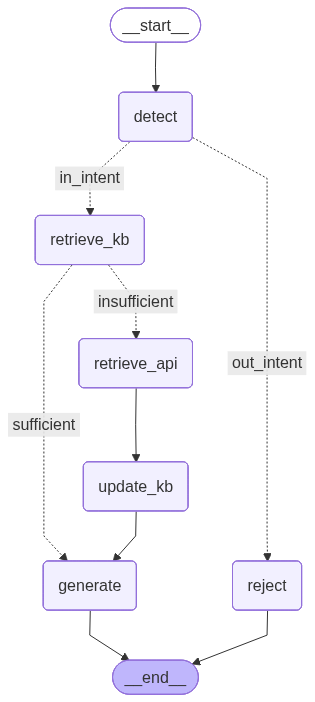

In [37]:
display(Image(agent.get_graph(xray=1).draw_mermaid_png()))